In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, List, Tuple, Dict, Any

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_squared_error, r2_score, confusion_matrix, classification_report
)

# Display Settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
pd.options.display.max_columns = 120
import warnings
warnings.filterwarnings('ignore')

## About Dataset

At LOL Bank Pvt. Ltd., protecting customers and the bank from fraudulent transactions is a priority. This dataset contains historical transaction records that will be used to build and evaluate automated fraud detection models capable of flagging suspicious activity in (near) real time while keeping false positives low.

### Dataset at a glance
- Size: 200,000 rows × 24 columns
- Column types: 20 object/text, 2 numeric (float), 2 integer
- Target: `Is_Fraud` — binary flag (0 = legitimate, 1 = fraudulent). Expect class imbalance (fraud is typically a small fraction).
- Typical fields include customer identifiers, transaction amounts/timestamps, merchant and device metadata, and textual descriptions.

### Column descriptions
- Customer_ID: Unique identifier for each customer.
- Customer_Name: Customer's name (identifying information — treat as PII).
- Gender: Customer gender (e.g., Male, Female, Other).
- Age: Customer age at transaction time.
- State: Customer's state/region.
- City: Customer's city.
- Bank_Branch: Branch where the account is held.
- Account_Type: Type of account (e.g., Savings, Checking, Business).
- Transaction_ID: Unique identifier for each transaction.
- Transaction_Date: Date of the transaction.
- Transaction_Time: Time of the transaction.
- Transaction_Amount: Monetary amount of the transaction.
- Merchant_ID: Unique merchant identifier.
- Transaction_Type: Nature of transaction (e.g., Withdrawal, Deposit, Transfer).
- Merchant_Category: Merchant category (e.g., Retail, Online, Travel).
- Account_Balance: Account balance after the transaction.
- Transaction_Device: Interface used (e.g., Mobile app, POS, ATM).
- Transaction_Location: Location string (e.g., "City, State").
- Device_Type: Device category (e.g., Smartphone, Desktop).
- Is_Fraud: Binary label indicating fraud (1) or not (0).
- Transaction_Currency: Currency used (e.g., INR, USD).
- Customer_Contact: Customer phone (PII).
- Transaction_Description: Short text describing the transaction.
- Customer_Email: Customer email (PII).

### Problem statement
Build a robust, scalable fraud detection system that:
- Detects fraudulent transactions with high recall while keeping false positives low.
- Operates (near) real time for timely intervention.
- Adapts to evolving fraud patterns through retraining and monitoring.

### Suggested solution approach
- Data engineering: parse timestamps, normalize amounts, extract location/device features, and derive behavioral features (e.g., transaction frequency, avg amount per customer).
- Handle PII: mask or remove direct identifiers (names, emails, contacts) and follow privacy-compliant procedures.
- Address class imbalance: use resampling, class weighting, anomaly detection, or specialized algorithms.
- Modeling: baseline classifiers (Logistic Regression, Random Forest), gradient boosting, and anomaly detection; consider online or incremental learning for real-time adaptation.
- Validation: use time-aware splits, precision/recall/F1, and business-focused metrics (false positive cost).
- Deployment: low-latency scoring, alert pipeline for investigations, and a feedback loop for label updates and retraining.

### Challenges & considerations
- Class imbalance and rare-event detection.
- Data quality and label noise.
- Privacy and regulatory constraints around PII.
- Feature drift over time — plan for model monitoring and retraining.
- Latency and scalability requirements for production scoring.

### Expected outcomes
- Early detection of fraudulent transactions, reducing financial loss.
- Actionable real-time alerts for bank investigators.
- Improved customer trust and compliance with regulatory requirements.
- A maintainable pipeline for continuous improvement as fraud patterns evolve.


In [15]:
# --- Loading & EDA Functions ---
def load_csv(path: str, nrows: Optional[int] = None, **read_kwargs) -> pd.DataFrame:
    """Load a CSV into a DataFrame."""
    try:
        return pd.read_csv(path, nrows=nrows, **read_kwargs)
    except FileNotFoundError as e:
        raise FileNotFoundError(f"CSV file not found: {path}") from e

In [16]:
def overview(df: pd.DataFrame) -> Dict[str, Any]:
    """Return simple overview info about a DataFrame."""
    return {
        "shape": df.shape,
        "dtypes": df.dtypes.value_counts(),
        "missing": df.isnull().sum().sum()
    }

In [17]:
def eda_descriptive(df: pd.DataFrame, n_head: int = 5):
    """Print descriptive EDA summaries."""
    print(f"Shape: {df.shape}")
    print("\nColumn Data Types:\n", df.dtypes.value_counts())
    
    # Check for missing values
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    if not missing.empty:
        print("\nColumns with Missing Values:\n", missing)
    else:
        print("\nNo missing values found.")

    # Target balance check
    if "Is_Fraud" in df.columns:
        print("\nTarget Class Balance (Is_Fraud):\n", df["Is_Fraud"].value_counts(normalize=True))

In [2]:

def plot_target_distribution(df: pd.DataFrame, target: str = "Is_Fraud"):
    """Plot the balance of the target variable."""
    if target not in df.columns:
        return
    plt.figure(figsize=(6, 4))
    sns.countplot(x=df[target])
    plt.title(f"Target Distribution: {target}")
    plt.show()

# --- Preprocessing Functions ---
def clean_missing(df: pd.DataFrame, drop_threshold: float = 0.5) -> pd.DataFrame:
    """Drop columns with too many missing values and fill remainder."""
    df = df.copy()
    # Drop columns with > 50% missing
    frac_missing = df.isnull().mean()
    drop_cols = frac_missing[frac_missing > drop_threshold].index.tolist()
    if drop_cols:
        df.drop(columns=drop_cols, inplace=True)
        print(f"Dropped cols > {drop_threshold} missing: {drop_cols}")
    
    # Fill remaining numeric with 0, object with 'Unknown'
    num_cols = df.select_dtypes(include=[np.number]).columns
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    
    df[num_cols] = df[num_cols].fillna(0)
    df[cat_cols] = df[cat_cols].fillna('Unknown')
    return df

def feature_engineering_dates(df: pd.DataFrame) -> pd.DataFrame:
    """Convert string dates/times to numeric features."""
    df = df.copy()
    
    # Process Transaction Date
    if 'Transaction_Date' in df.columns:
        # Assuming format like '23-01-2025' or similar standard format
        df['Trans_Month'] = pd.to_datetime(df['Transaction_Date'], errors='coerce').dt.month
        df['Trans_Day'] = pd.to_datetime(df['Transaction_Date'], errors='coerce').dt.day
        df['Trans_Weekday'] = pd.to_datetime(df['Transaction_Date'], errors='coerce').dt.dayofweek
    
    # Process Transaction Time
    if 'Transaction_Time' in df.columns:
        # Assuming format like '16:04:07'
        df['Trans_Hour'] = pd.to_datetime(df['Transaction_Time'], format='%H:%M:%S', errors='coerce').dt.hour

    return df

def drop_irrelevant_columns(df: pd.DataFrame, columns_to_drop: List[str]) -> pd.DataFrame:
    """Drop columns that are ID-based, PII, or high cardinality strings."""
    df = df.copy()
    existing_cols = [col for col in columns_to_drop if col in df.columns]
    if existing_cols:
        df.drop(columns=existing_cols, inplace=True)
        print(f"Dropped columns: {existing_cols}")
    return df

def encode_categorical(df: pd.DataFrame) -> pd.DataFrame:
    """One-hot encode remaining categorical columns."""
    df = df.copy()
    # Select object columns that are NOT the target
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    if not cat_cols:
        return df
        
    print(f"Encoding categorical columns: {cat_cols}")
    # drop_first=True helps reduce dimensionality and multicollinearity
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
    return df

def split_and_scale(df: pd.DataFrame, target: str) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """Split data into X/y, Train/Test, and Scale numeric features."""
    
    # 1. Separate X and y
    X = df.drop(columns=[target])
    y = df[target]
    
    # 2. Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # 3. Scaling
    scaler = StandardScaler()
    
    # Identify boolean/encoded columns (0/1) vs numeric continuous columns
    # We generally only want to scale continuous columns, not one-hot encoded ones
    # A heuristic: scale columns with > 2 unique values
    cols_to_scale = [col for col in X_train.columns if X_train[col].nunique() > 2]
    
    if cols_to_scale:
        X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
        X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])
        
    return X_train, X_test, y_train, y_test

# --- Modeling Functions ---
def train_model(X_train, y_train, model_type="logistic"):
    if model_type == "logistic":
        # Class_weight='balanced' helps with the fraud imbalance
        model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
    elif model_type == "random_forest":
        model = RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced', n_jobs=-1)
    
    print(f"Training {model_type}...")
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    
    print("\n--- Evaluation Metrics ---")
    print(f"Accuracy:  {accuracy_score(y_test, preds):.4f}")
    print(f"Precision: {precision_score(y_test, preds, zero_division=0):.4f}")
    print(f"Recall:    {recall_score(y_test, preds):.4f}")
    print(f"F1 Score:  {f1_score(y_test, preds):.4f}")
    
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

## Preprocessing

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Dict, Any, List, Tuple
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_squared_error, r2_score
)

# Handle display function for non-Jupyter environments
try:
    from IPython.display import display
except ImportError:
    def display(obj):
        print(obj)

def load_csv(path: str, nrows: Optional[int] = None, **read_kwargs) -> pd.DataFrame:
    """Load a CSV into a DataFrame."""
    try:
        return pd.read_csv(path, nrows=nrows, **read_kwargs)
    except FileNotFoundError as e:
        raise FileNotFoundError(f"CSV file not found: {path}") from e

def overview(df: pd.DataFrame, n: int = 5) -> Dict[str, Any]:
    """Return simple overview info about a DataFrame."""
    return {
        "shape": df.shape,
        "dtypes": df.dtypes,
        "head": df.head(n),
        "missing": df.isnull().sum().sort_values(ascending=False).head(20)
    }

def eda_descriptive(df: pd.DataFrame, n_head: int = 5) -> dict:
    """Return and print descriptive EDA summaries."""
    out = {}
    out["shape"] = df.shape
    out["head"] = df.head(n_head)
    out["dtypes"] = df.dtypes.value_counts().to_dict()
    out["missing_count"] = df.isnull().sum().sort_values(ascending=False).head(30)
    out["missing_pct"] = (df.isnull().mean() * 100).sort_values(ascending=False).head(30)
    
    # Check if there are numeric columns before describing
    numeric_df = df.select_dtypes(include=[np.number])
    if not numeric_df.empty:
        out["numeric_desc"] = numeric_df.describe().T
    else:
        out["numeric_desc"] = pd.DataFrame()

    out["categorical_vals"] = {
        c: int(df[c].nunique()) for c in df.select_dtypes(include=["object", "category"]).columns
    }
    
    # print short summary
    print("Shape:", out["shape"])
    print("\nTop dtypes:\n", out["dtypes"])
    print("\nHead:")
    display(out["head"])
    print("\nTop missing (count):")
    display(out["missing_count"])
    print("\nTop missing (pct):")
    display(out["missing_pct"])
    print("\nNumeric summary (top rows):")
    display(out["numeric_desc"].head(10))
    print("\nCategorical cardinalities (sample 20):")
    display(pd.Series(out["categorical_vals"]).sort_values(ascending=False).head(20))
    return out


def plot_target_distribution(df: pd.DataFrame, target: str = "Is_Fraud"):
    if target not in df.columns:
        print(f"Target '{target}' not found; available: {list(df.columns)[:40]}")
        return
    vc = df[target].value_counts(dropna=False)
    print("Value counts:\n", vc)
    plt.figure(figsize=(8, 4))
    sns.barplot(x=vc.index.astype(str), y=vc.values)
    plt.title(f"Target distribution: {target}")
    plt.ylabel("count")
    plt.show()

# def numeric_eda_plots(df: pd.DataFrame, target: str = "Is_Fraud", top_corr: int = 12):
#     nums = df.select_dtypes(include=[np.number]).copy()
#     if nums.shape[1] == 0:
#         print("No numeric columns to analyze.")
#         return
#     # correlations (with target if present)
#     if target in nums.columns:
#         corr = nums.corr()[target].abs().sort_values(ascending=False).head(top_corr)
#         print("Top correlations with target:")
#         display(corr)
#     else:
#         corrmat = nums.corr()
#         top_pairs = (corrmat.abs().unstack().sort_values(ascending=False).drop_duplicates().head(top_corr))
#         print("Top numeric correlations (pairs):")
#         display(top_pairs)
    
#     # boxplots for top numeric columns vs target (if classification)
#     top_cols = nums.columns.drop([target]) if target in nums.columns else nums.columns
#     # Limit to first 6 to avoid too many plots
#     top_cols = top_cols[:6]
    
#     for c in top_cols:
#         plt.figure(figsize=(8, 3))
#         if target in df.columns:
#             sns.boxplot(x=df[target].astype(str), y=df[c])
#             plt.title(f"{c} by {target}")
#         else:
#             sns.histplot(df[c].dropna(), kde=True)
#             plt.title(c)
#         plt.show()





def numeric_eda_plots(df: pd.DataFrame, target: str = "Is_Fraud", top_corr: int = 12):
    """
    Plots numeric distributions. 
    - If target exists: Plots Boxplots and includes the count (n) in the x-axis labels.
    - If no target: Plots Histograms and labels the bar counts.
    """
    nums = df.select_dtypes(include=[np.number]).copy()
    if nums.shape[1] == 0:
        print("No numeric columns to analyze.")
        return

    # --- Correlation Logic ---
    if target in nums.columns:
        corr = nums.corr()[target].abs().sort_values(ascending=False).head(top_corr)
        print("Top correlations with target:")
        display(corr.to_frame())
    else:
        corrmat = nums.corr()
        top_pairs = (corrmat.abs().unstack().sort_values(ascending=False).drop_duplicates().head(top_corr))
        print("Top numeric correlations (pairs):")
        display(top_pairs.to_frame())
    
    # --- Plotting Logic ---
    top_cols = nums.columns.drop([target]) if target in nums.columns else nums.columns
    # Limit to first 6 to avoid too many plots
    top_cols = top_cols[:6]
    
    for c in top_cols:
        plt.figure(figsize=(8, 4))
        
        # 1. TARGET EXISTS: Boxplot with Counts on X-Axis
        if target in df.columns:
            # Create the boxplot
            ax = sns.boxplot(x=df[target].astype(str), y=df[c])
            plt.title(f"{c} by {target}")
            
            # Calculate counts for the target categories
            counts = df[target].astype(str).value_counts()
            
            # Update X-axis labels to include the count (n=...)
            x_labels = [label.get_text() for label in ax.get_xticklabels()]
            new_labels = [f"{lbl}\n(n={counts.get(lbl, 0)})" for lbl in x_labels]
            ax.set_xticklabels(new_labels)

        # 2. NO TARGET: Histogram with Bar Labels
        else:
            ax = sns.histplot(df[c].dropna(), kde=True)
            plt.title(c)
            
            # Add labels to the top of histogram bars
            # Note: kde=True adds a line, but bar_label attaches to the bar containers
            for container in ax.containers:
                ax.bar_label(container)

        plt.tight_layout()
        plt.show()

def categorical_eda(df: pd.DataFrame, max_cols: int = 10):
    cats = df.select_dtypes(include=["object", "category"]).columns.tolist()
    if not cats:
        print("No categorical columns.")
        return
    sample = cats[:max_cols]
    for c in sample:
        vc = df[c].value_counts(dropna=False).head(15)
        print(f"\nColumn: {c} (n_unique={df[c].nunique()})")
        display(vc)
        plt.figure(figsize=(8, 3))
        sns.barplot(x=vc.values, y=[str(x) for x in vc.index])
        plt.title(c)
        plt.show()

def clean_missing(
     df: pd.DataFrame,
     drop_threshold: float = 0.5,
     fill_method: Optional[str] = None,
     fill_value: Optional[Any] = None
) -> pd.DataFrame:
    """
    Clean missing values:
    - Drop columns with fraction of missing > drop_threshold.
    - If fill_method is 'ffill' or 'bfill' uses pandas fillna.
    - If fill_value provided, fills remaining NA with that value.
    """
    df = df.copy()
    frac_missing = df.isnull().mean()
    drop_cols = frac_missing[frac_missing > drop_threshold].index.tolist()
    if drop_cols:
        df.drop(columns=drop_cols, inplace=True)
    
    # Note: method='ffill' is deprecated in newer pandas versions, 
    # but kept here to preserve logic. 
    if fill_method in ("ffill", "bfill"):
        df.fillna(method=fill_method, inplace=True)
    if fill_value is not None:
        df.fillna(fill_value, inplace=True)
    return df

def plot_missing_heatmap(df: pd.DataFrame, sample_frac: float = 0.2):
    """
    Plot a heatmap of missing values.
    Yellow lines indicate missing data.
    """
    # Check if there is any missing data first
    if df.isnull().sum().sum() == 0:
        print("Good news: No missing values found in the DataFrame.")
        return

    # Sample for speed if dataset is large
    if len(df) > 50000 and sample_frac < 1.0:
        print(f"Plotting missingness on {sample_frac*100}% sample...")
        df_plot = df.sample(frac=sample_frac, random_state=42)
    else:
        df_plot = df
        
    plt.figure(figsize=(12, 6))
    sns.heatmap(df_plot.isnull(), cbar=False, yticklabels=False, cmap='viridis')
    plt.title("Missing Values Map (Yellow = Missing)")
    plt.xlabel("Columns")
    plt.show()

def drop_irrelevant_columns(df: pd.DataFrame, columns_to_drop: List[str]) -> pd.DataFrame:
    """Drop irrelevant columns from the DataFrame."""
    df = df.copy()
    existing_cols = [col for col in columns_to_drop if col in df.columns]
    if existing_cols:
        df.drop(columns=existing_cols, inplace=True)
        print(f"Dropped columns: {existing_cols}")
    else:
        print("No irrelevant columns found to drop.")
    return df

def feature_engineering_advanced(df: pd.DataFrame) -> pd.DataFrame:
    """
    Custom preprocessing based on the specific cardinality analysis.
    1. Extracts Hour from Transaction_Time.
    2. Extracts Day/Weekday from Transaction_Date.
    3. Frequency Encodes high-cardinality locations (City, Branch).
    """
    df = df.copy()
    
    # --- 1. TIME & DATE HANDLING ---
    print("...processing Date and Time")
    
    # Clean Transaction_Time (assuming format like "14:30:00" or similar)
    # We take the first 2 characters to get the Hour
    try:
        df['Transaction_Hour'] = pd.to_numeric(df['Transaction_Time'].astype(str).str[:2], errors='coerce').fillna(0).astype(int)
        df.drop(columns=['Transaction_Time'], inplace=True)
    except Exception as e:
        print(f"Could not parse Transaction_Time: {e}")

    # Clean Transaction_Date (assuming strings, convert to datetime)
    try:
        # distinct count is 31, likely just days, but let's try standard parsing
        temp_date = pd.to_datetime(df['Transaction_Date'], errors='coerce')
        df['Transaction_Day'] = temp_date.dt.day.fillna(0).astype(int)
        df['Transaction_Weekday'] = temp_date.dt.dayofweek.fillna(0).astype(int)
        df.drop(columns=['Transaction_Date'], inplace=True)
    except Exception as e:
        print(f"Could not parse Transaction_Date: {e}")

    # --- 2. FREQUENCY ENCODING (High Cardinality) ---
    # These columns are too big for One-Hot (140+ cols), but useful for patterns
    high_card_cols = ['City', 'Bank_Branch', 'Transaction_Location']
    
    for col in high_card_cols:
        if col in df.columns:
            print(f"...Frequency encoding: {col}")
            # Map the column values to their frequency (count)
            freq_map = df[col].value_counts(normalize=True) # normalize=True gives percentage
            df[f'{col}_Freq'] = df[col].map(freq_map)
            # Drop original string column
            df.drop(columns=[col], inplace=True)

    return df

def encode_categorical(
     df: pd.DataFrame, 
     columns: Optional[List[str]] = None, 
     drop_first: bool = True,
     max_cardinality: int = 50 # Set to 50 to include 'State' (34) but exclude others
) -> pd.DataFrame:
    df = df.copy()
    if columns is None:
         columns = df.select_dtypes(include=["object", "category"]).columns.tolist()
    
    if not columns:
         return df

    cols_to_encode = []
    cols_to_drop = []

    for col in columns:
        unique_count = df[col].nunique()
        if unique_count > max_cardinality:
            cols_to_drop.append(col)
            print(f"Warning: Column '{col}' has {unique_count} unique values. Dropping (Too high for OneHot).")
        else:
            cols_to_encode.append(col)

    if cols_to_drop:
        df.drop(columns=cols_to_drop, inplace=True)

    if cols_to_encode:
        print(f"One-Hot Encoding: {cols_to_encode}")
        # dtype=int ensures 0/1 instead of True/False
        df = pd.get_dummies(df, columns=cols_to_encode, drop_first=drop_first, dtype=int)
        
    return df

def split_X_y(df: pd.DataFrame, target: str) -> Tuple[pd.DataFrame, pd.Series]:
    """Split DataFrame into features X and target y (with safety check)."""
    if target not in df.columns:
         raise KeyError(f"target column '{target}' not found in DataFrame; available columns: {list(df.columns)[:50]}")
    X = df.drop(columns=[target])
    y = df[target]
    return X, y

def scale_features(
     X_train: pd.DataFrame,
     X_test: pd.DataFrame,
     method: str = "standard"
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Scale numeric features using StandardScaler or MinMaxScaler."""
    scaler = StandardScaler() if method == "standard" else MinMaxScaler()
    num_cols = X_train.select_dtypes(include=[np.number]).columns.intersection(
        X_test.select_dtypes(include=[np.number]).columns
    )
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    
    if len(num_cols) == 0:
        return X_train_scaled, X_test_scaled
        
    X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])
    return X_train_scaled, X_test_scaled

def train_simple_model(
     X_train: pd.DataFrame,
     y_train: pd.Series,
     problem: str = "classification",
     model_name: str = "logistic",
     random_state: int = 42,
     **kwargs
) -> Any:
    """Train a simple model. Returns trained estimator."""
    
    # 1. Convert booleans to integers if any exist (safety net)
    X_train = X_train.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)
    
    # 2. Select numeric types (including the newly converted ints)
    X_train_num = X_train.select_dtypes(include=[np.number])
    
    # Check if we lost columns
    if X_train_num.shape[1] != X_train.shape[1]:
        dropped = X_train.shape[1] - X_train_num.shape[1]
        print(f"Notice: Dropped {dropped} non-numeric columns. Training shape: {X_train_num.shape}")
    
    if problem == "classification":
         if model_name == "logistic":
              # Added class_weight='balanced' default if not provided
              if "class_weight" not in kwargs:
                  kwargs["class_weight"] = "balanced"
              model = LogisticRegression(max_iter=1000, random_state=random_state, **kwargs)
         elif model_name == "random_forest":
              if "class_weight" not in kwargs:
                  kwargs["class_weight"] = "balanced"
              model = RandomForestClassifier(random_state=random_state, **kwargs)
         else:
              raise ValueError("Unsupported classification model_name")
    else:
         if model_name == "linear":
              model = LinearRegression(**kwargs)
         elif model_name == "random_forest":
              model = RandomForestRegressor(random_state=random_state, **kwargs)
         else:
              raise ValueError("Unsupported regression model_name")
    
    model.fit(X_train_num, y_train)
    return model

def evaluate_model(
     model,
     X_test: pd.DataFrame,
     y_test: pd.Series,
     problem: str = "classification"
) -> Dict[str, float]:
    """Evaluate model and return common metrics."""
    preds = model.predict(X_test)
    if problem == "classification":
         unique_vals = np.unique(y_test)
         binary = unique_vals.size == 2
         if binary:
             return {
                 "accuracy": float(accuracy_score(y_test, preds)),
                 "precision": float(precision_score(y_test, preds, average="binary", zero_division=0)),
                 "recall": float(recall_score(y_test, preds, average="binary", zero_division=0)),
                 "f1": float(f1_score(y_test, preds, average="binary", zero_division=0)),
             }
         else:
             return {
                 "accuracy": float(accuracy_score(y_test, preds)),
                 "precision": float(precision_score(y_test, preds, average="macro", zero_division=0)),
                 "recall": float(recall_score(y_test, preds, average="macro", zero_division=0)),
                 "f1": float(f1_score(y_test, preds, average="macro", zero_division=0)),
             }
    else:
         mse = mean_squared_error(y_test, preds)
         return {
              "mse": float(mse),
              "rmse": float(np.sqrt(mse)),
              "r2": float(r2_score(y_test, preds)),
         }

def split_train_test(
     X: pd.DataFrame,
     y: pd.Series,
     test_size: float = 0.2,
     random_state: int = 42,
     stratify: Optional[pd.Series] = None
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """Convenience wrapper around sklearn.model_selection.train_test_split."""
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=stratify)

# --------------------------------------------------------------------------------
# EXAMPLE USAGE (Commented out because 'df' is not defined in this snippet)
# --------------------------------------------------------------------------------
# if __name__ == "__main__":
#     # 1. Load Data
#     # df = load_csv("data.csv")
#
#     # 2. EDA
#     # overview(df)
#     # eda_descriptive(df)
#     # plot_target_distribution(df, target="Is_Fraud")
#
#     # 3. Preprocessing
#     # df = clean_missing(df)
#     # df = encode_categorical(df)
#     # X, y = split_X_y(df, target="Is_Fraud")
#
#     # 4. Split and Scale
#     # X_train, X_test, y_train, y_test = split_train_test(X, y, stratify=y)
#     # X_train_scaled, X_test_scaled = scale_features(X_train, X_test)
#
#     # 5. Train
#     # model = train_simple_model(X_train_scaled, y_train, problem="classification", model_name="logistic")
#
#     # 6. Evaluate
#     # metrics = evaluate_model(model, X_test_scaled, y_test, problem="classification")
#     # print(metrics)

Loaded: (200000, 24)
Overview shape: (200000, 24)
--- Missing Data Analysis ---
Good news: No missing values found in the DataFrame.

--- Target Distribution (Class Imbalance) ---
Fraud Cases: 10088 (5.04%)


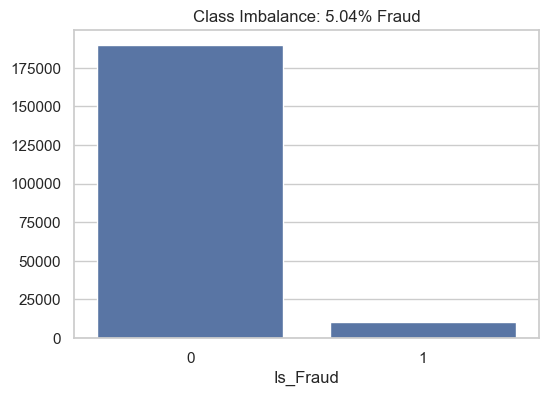


NOTE: Because of this imbalance, we use class_weight='balanced'.
After clean_missing: (200000, 24)
Dropped columns: ['Customer_ID', 'Customer_Name', 'Merchant_ID', 'Customer_Contact', 'Customer_Email', 'Transaction_ID', 'Transaction_Description', 'Transaction_Currency']
After dropping irrelevant columns: (200000, 16)
...processing Date and Time
...Frequency encoding: City
...Frequency encoding: Bank_Branch
...Frequency encoding: Transaction_Location
After feature_engineering_advanced: (200000, 17)
Running descriptive EDA...
Shape: (200000, 17)

Top dtypes:
 {dtype('O'): 7, dtype('int64'): 5, dtype('float64'): 5}

Head:


,Gender,Age,State,Account_Type,Transaction_Amount,Transaction_Type,Merchant_Category,Account_Balance,Transaction_Device,Device_Type,Is_Fraud,Transaction_Hour,Transaction_Day,Transaction_Weekday,City_Freq,Bank_Branch_Freq,Transaction_Location_Freq
0,Male,60,Kerala,Savings,32415.45,Transfer,Restaurant,74557.27,Voice Assistant,POS,0,16,23,3,0.005700,0.005700,0.005700
1,Female,51,Maharashtra,Business,43622.60,Bill Payment,Restaurant,74622.66,POS Mobile Device,Desktop,0,17,11,5,0.005625,0.005625,0.005625
2,Male,20,Bihar,Savings,63062.56,Bill Payment,Groceries,66817.99,ATM,Desktop,0,3,25,5,0.005695,0.005695,0.005695
3,Female,57,Tamil Nadu,Business,14000.72,Debit,Entertainment,58177.08,POS Mobile App,Mobile,0,12,19,6,0.005805,0.005805,0.005805
4,Female,43,Punjab,Savings,18335.16,Transfer,Entertainment,16108.56,Virtual Card,Mobile,0,18,30,3,0.005860,0.005860,0.005860



Top missing (count):


Gender                       0
Age                          0
State                        0
Account_Type                 0
Transaction_Amount           0
Transaction_Type             0
Merchant_Category            0
Account_Balance              0
Transaction_Device           0
Device_Type                  0
Is_Fraud                     0
Transaction_Hour             0
Transaction_Day              0
Transaction_Weekday          0
City_Freq                    0
Bank_Branch_Freq             0
Transaction_Location_Freq    0
dtype: int64


Top missing (pct):


Gender                       0.0
Age                          0.0
State                        0.0
Account_Type                 0.0
Transaction_Amount           0.0
Transaction_Type             0.0
Merchant_Category            0.0
Account_Balance              0.0
Transaction_Device           0.0
Device_Type                  0.0
Is_Fraud                     0.0
Transaction_Hour             0.0
Transaction_Day              0.0
Transaction_Weekday          0.0
City_Freq                    0.0
Bank_Branch_Freq             0.0
Transaction_Location_Freq    0.0
dtype: float64


Numeric summary (top rows):


,count,mean,std,min,25%,50%,75%,max
Age,200000.0,44.015110,15.288774,18.00000,31.000000,44.000000,57.000000,70.000000
Transaction_Amount,200000.0,49538.015554,28551.874004,10.29000,24851.345000,49502.440000,74314.625000,98999.980000
Account_Balance,200000.0,52437.988784,27399.507128,5000.82000,28742.395000,52372.555000,76147.670000,99999.950000
Is_Fraud,200000.0,0.050440,0.218852,0.00000,0.000000,0.000000,0.000000,1.000000
Transaction_Hour,200000.0,11.490420,6.917094,0.00000,6.000000,11.000000,17.000000,23.000000
Transaction_Day,200000.0,15.515985,8.672289,1.00000,8.000000,16.000000,23.000000,31.000000
Transaction_Weekday,200000.0,2.972560,1.939553,0.00000,1.000000,3.000000,5.000000,6.000000
City_Freq,200000.0,0.008764,0.007760,0.00556,0.005860,0.006045,0.007420,0.040675
Bank_Branch_Freq,200000.0,0.008764,0.007760,0.00556,0.005860,0.006045,0.007420,0.040675
Transaction_Location_Freq,200000.0,0.007930,0.005461,0.00556,0.005855,0.006020,0.007405,0.029770



Categorical cardinalities (sample 20):


State                 34
Transaction_Device    20
Merchant_Category      6
Transaction_Type       5
Device_Type            4
Account_Type           3
Gender                 2
dtype: int64

Numeric EDA plots:
Top correlations with target:


,Is_Fraud
Is_Fraud,1.000000
Transaction_Location_Freq,0.002810
Transaction_Weekday,0.002582
Transaction_Amount,0.002100
Transaction_Hour,0.001960
Age,0.001517
City_Freq,0.000360
Bank_Branch_Freq,0.000360
Transaction_Day,0.000135
Account_Balance,0.000125


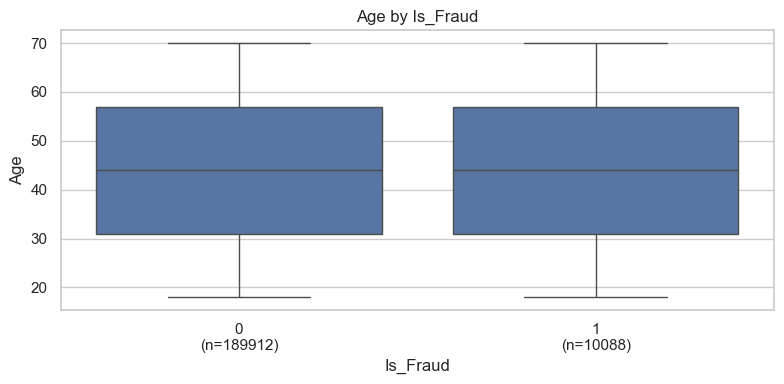

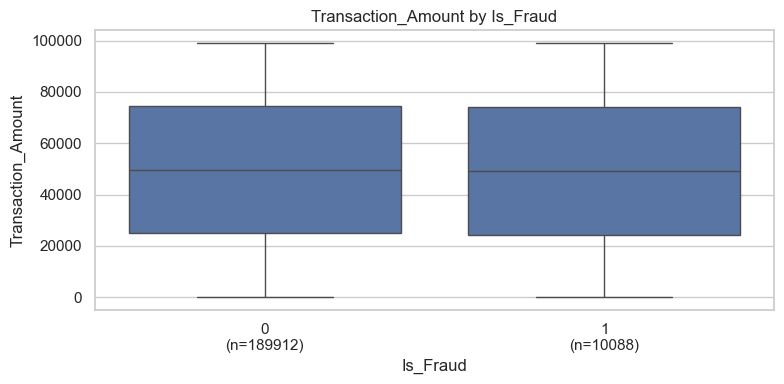

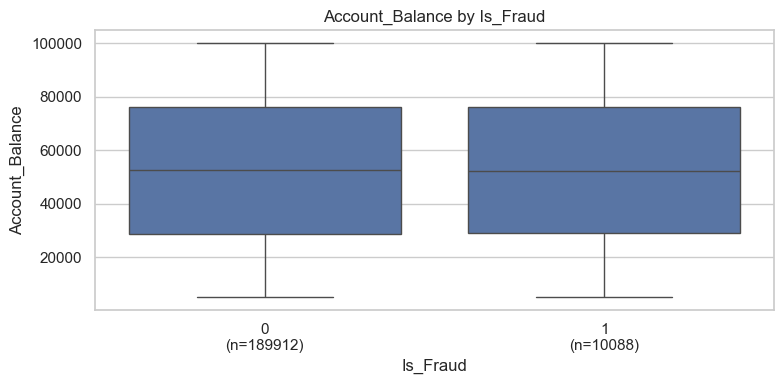

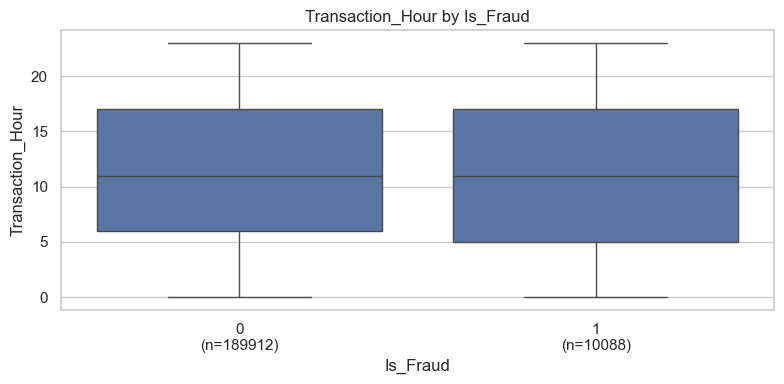

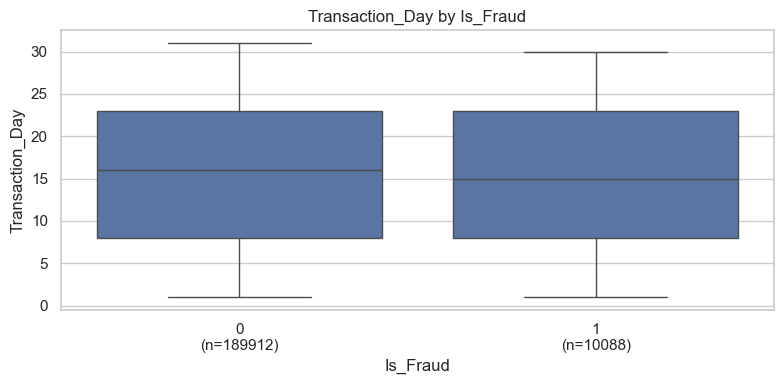

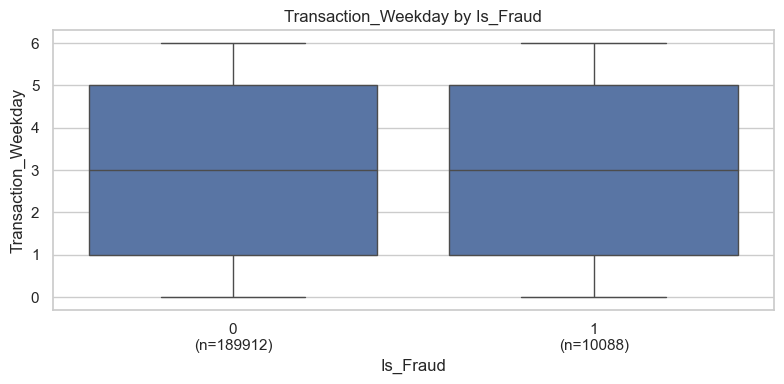

Categorical EDA (first 8):

Column: Gender (n_unique=2)


Gender
Male      100452
Female     99548
Name: count, dtype: int64

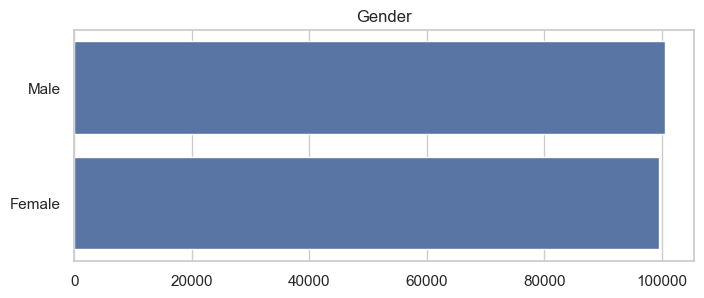


Column: State (n_unique=34)


State
Nagaland             6031
Meghalaya            6003
Uttar Pradesh        6002
Uttarakhand          5985
Lakshadweep          5954
Telangana            5952
Haryana              5947
Delhi                5943
Kerala               5933
Madhya Pradesh       5928
Arunachal Pradesh    5919
Punjab               5912
Gujarat              5901
Odisha               5899
Jharkhand            5898
Name: count, dtype: int64

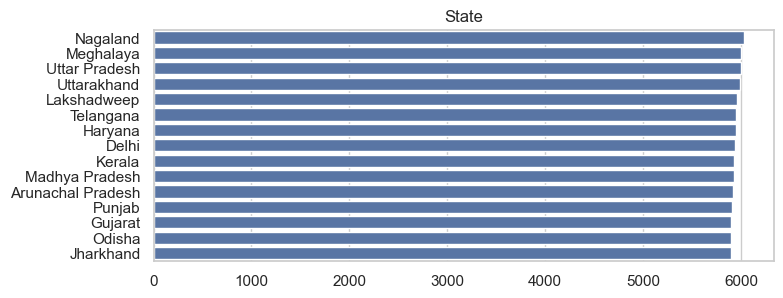


Column: Account_Type (n_unique=3)


Account_Type
Checking    66924
Savings     66593
Business    66483
Name: count, dtype: int64

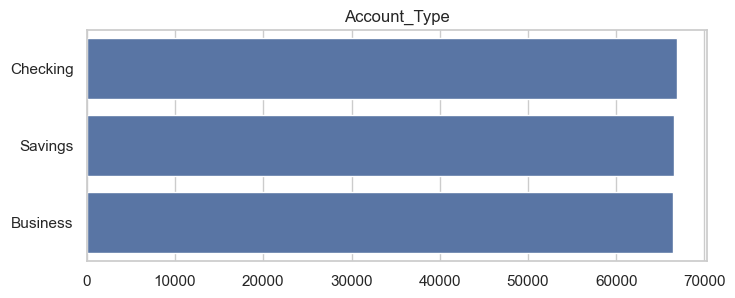


Column: Transaction_Type (n_unique=5)


Transaction_Type
Credit          40180
Debit           40050
Bill Payment    40040
Transfer        39953
Withdrawal      39777
Name: count, dtype: int64

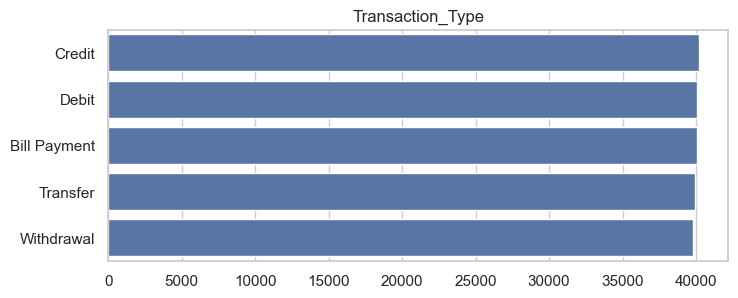


Column: Merchant_Category (n_unique=6)


Merchant_Category
Restaurant       33525
Entertainment    33421
Electronics      33409
Clothing         33340
Groceries        33187
Health           33118
Name: count, dtype: int64

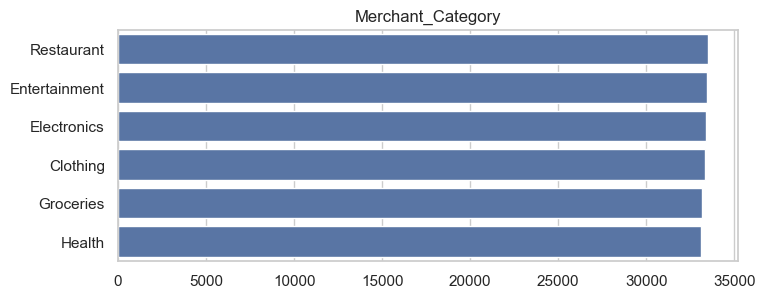


Column: Transaction_Device (n_unique=20)


Transaction_Device
Self-service Banking Machine    21707
ATM                             21200
ATM Booth Kiosk                 21149
Debit/Credit Card                8273
Smart Card                       8133
Wearable Device                  8128
Virtual Card                     8059
Tablet                           8059
Desktop/Laptop                   8057
Voice Assistant                  8039
POS Mobile Device                8006
Banking Chatbot                  7995
Web Browser                      7981
Biometric Scanner                7952
QR Code Scanner                  7938
Name: count, dtype: int64

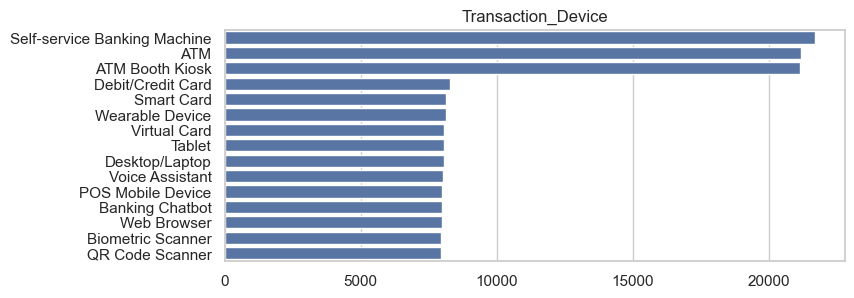


Column: Device_Type (n_unique=4)


Device_Type
POS        50111
ATM        50055
Mobile     49962
Desktop    49872
Name: count, dtype: int64

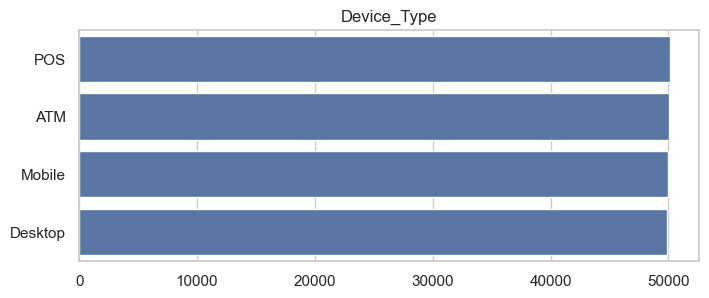

One-Hot Encoding: ['Gender', 'State', 'Account_Type', 'Transaction_Type', 'Merchant_Category', 'Transaction_Device', 'Device_Type']
After encode_categorical: (200000, 84)
Split X/y: (200000, 83) (200000,)
Train/Test sizes: (160000, 83) (40000, 83)
Scaled numeric cols: 83
Model trained.
Metrics: {'accuracy': 0.51405, 'precision': 0.050498785341396596, 'recall': 0.4777506112469438, 'f1': 0.09134255796559461}


In [4]:

# ==========================================
# 2. RUNNER CELL
# ==========================================

CSV = r"D:/Portofolio/Fraud Detection TXN/Bank_Transaction_Fraud_Detection.csv"

# 1. Load
try:
    df = load_csv(CSV)
    print("Loaded:", df.shape)
except Exception as e:
    print("Load error:", e)
    raise

# 2. Overview
try:
    info = overview(df, n=3)
    print("Overview shape:", info["shape"])
except Exception as e:
    print("Overview error:", e)

# 3. EDA Visuals
print("--- Missing Data Analysis ---")
plot_missing_heatmap(df, sample_frac=0.2)

print("\n--- Target Distribution (Class Imbalance) ---")
target_col = "Is_Fraud"
if target_col in df.columns:
    val_counts = df[target_col].value_counts()
    fraud_pct = (val_counts.get(1, 0) / len(df)) * 100
    print(f"Fraud Cases: {val_counts.get(1, 0)} ({fraud_pct:.2f}%)")
    
    plt.figure(figsize=(6, 4))
    sns.barplot(x=val_counts.index.astype(str), y=val_counts.values)
    plt.title(f"Class Imbalance: {fraud_pct:.2f}% Fraud")
    plt.show()
    
    print("\nNOTE: Because of this imbalance, we use class_weight='balanced'.")

# 4. Clean
try:
    df = clean_missing(df)
    print("After clean_missing:", df.shape)
except Exception as e:
    print("clean_missing error:", e)

# 5. Drop Irrelevant
irrelevant_columns = [
    "Customer_ID", "Customer_Name","Merchant_ID", "Customer_Contact", "Customer_Email",
    "Transaction_ID", "Transaction_Description", "Transaction_Currency"
]
try:
    df = drop_irrelevant_columns(df, irrelevant_columns)
    print("After dropping irrelevant columns:", df.shape)
except Exception as e:
    print("Error during column removal:", e)
    raise

# 6. Feature Engineering (Critical for Memory/Time columns)
try:
    df = feature_engineering_advanced(df)
    print("After feature_engineering_advanced:", df.shape)
except Exception as e:
    print("feature_engineering error:", e)

# 7. Descriptive EDA
print("Running descriptive EDA...")
try:
    eda_summary = eda_descriptive(df, n_head=5)
    print("Numeric EDA plots:")
    numeric_eda_plots(df, target="Is_Fraud")
    print("Categorical EDA (first 8):")
    categorical_eda(df, max_cols=8)
except Exception as e:
    print("EDA error (skipping):", e)

# 8. Encode
try:
    # Changed: Added max_cardinality=50 to prevent Memory Error
    df = encode_categorical(df, drop_first=False, max_cardinality=50)
    print("After encode_categorical:", df.shape)
except Exception as e:
    print("encode_categorical error:", e)
    raise

# 9. Split X/y
target = "Is_Fraud"
try:
    X, y = split_X_y(df, target=target)
    print("Split X/y:", X.shape, y.shape)
except Exception as e:
    print("split_X_y error:", e)
    print("Columns sample:", list(df.columns)[:30])
    raise

# 10. Train/Test Split
try:
    X_train, X_test, y_train, y_test = split_train_test(X, y, test_size=0.2, random_state=42, stratify=None)
    print("Train/Test sizes:", X_train.shape, X_test.shape)
except Exception as e:
    print("split_train_test error:", e)
    raise

# 11. Scale
try:
    X_train_s, X_test_s = scale_features(X_train, X_test, method="standard")
    print("Scaled numeric cols:", X_train_s.select_dtypes(include=[np.number]).shape[1])
except Exception as e:
    print("scale_features error:", e)
    raise

# 12. Train
try:
    # Changed: Added class_weight='balanced' so the model doesn't just predict 0
    clf = train_simple_model(
        X_train_s.fillna(0), 
        y_train, 
        problem="classification", 
        model_name="logistic",
        class_weight="balanced"
    )
    print("Model trained.")
except Exception as e:
    print("train_simple_model error:", e)
    raise

# 13. Evaluate
try:
    metrics = evaluate_model(clf, X_test_s.fillna(0), y_test, problem="classification")
    print("Metrics:", metrics)
except Exception as e:
    print("evaluate_model error:", e)
    raise

In [5]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import logging
# from typing import Optional, Dict, Any, List, Tuple

# # Scikit-learn imports
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.linear_model import LogisticRegression, LinearRegression
# from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
# from sklearn.metrics import (
#     accuracy_score, precision_score, recall_score, f1_score,
#     mean_squared_error, r2_score
# )

# # --- Configuration & Setup ---

# # Configure Logging
# logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
# logger = logging.getLogger(__name__)

# # Handle display for non-Jupyter environments
# try:
#     from IPython.display import display
# except ImportError:
#     def display(obj: Any):
#         print(obj)

# # Set global plot style for "Advanced" look
# sns.set_theme(style="whitegrid", context="notebook", palette="viridis")
# plt.rcParams['figure.figsize'] = (10, 6)

# # --- Data Loading & Overview ---

# def load_csv(path: str, nrows: Optional[int] = None, **read_kwargs) -> pd.DataFrame:
#     """
#     Load a CSV file into a DataFrame with error handling.
#     """
#     try:
#         df = pd.read_csv(path, nrows=nrows, **read_kwargs)
#         logger.info(f"Successfully loaded data from {path}. Shape: {df.shape}")
#         return df
#     except FileNotFoundError as e:
#         logger.error(f"File not found: {path}")
#         raise e
#     except Exception as e:
#         logger.error(f"Error loading CSV: {e}")
#         raise e

# def overview(df: pd.DataFrame, n: int = 5) -> Dict[str, Any]:
#     """
#     Return a lightweight dictionary overview of the DataFrame.
#     """
#     return {
#         "shape": df.shape,
#         "dtypes": df.dtypes,
#         "head": df.head(n),
#         "missing": df.isnull().sum().sort_values(ascending=False).head(20)
#     }

# def eda_descriptive(df: pd.DataFrame, n_head: int = 5) -> Dict[str, Any]:
#     """
#     Print and return a comprehensive descriptive summary of the DataFrame.
#     """
#     out = {}
#     out["shape"] = df.shape
#     out["head"] = df.head(n_head)
#     out["dtypes"] = df.dtypes.value_counts().to_dict()
    
#     # Missing value analysis
#     out["missing_count"] = df.isnull().sum().sort_values(ascending=False).head(30)
#     out["missing_pct"] = (df.isnull().mean() * 100).sort_values(ascending=False).head(30)
    
#     # Numeric summary
#     numeric_df = df.select_dtypes(include=[np.number])
#     out["numeric_desc"] = numeric_df.describe().T if not numeric_df.empty else pd.DataFrame()

#     # Categorical cardinality
#     cat_cols = df.select_dtypes(include=["object", "category"]).columns
#     out["categorical_vals"] = {c: int(df[c].nunique()) for c in cat_cols}
    
#     # --- Display Logic ---
#     print(f"{'='*40}\nDATASET OVERVIEW\n{'='*40}")
#     print(f"Shape: {out['shape']}")
#     print(f"\nTop Dtypes:\n{out['dtypes']}")
    
#     print(f"\nHead ({n_head} rows):")
#     display(out["head"])
    
#     if out["missing_count"].sum() > 0:
#         print("\nTop Missing Columns (Count):")
#         display(out["missing_count"][out["missing_count"] > 0])
#         print("\nTop Missing Columns (%):")
#         display(out["missing_pct"][out["missing_pct"] > 0])
#     else:
#         print("\nNo missing values found.")

#     if not out["numeric_desc"].empty:
#         print("\nNumeric Summary (Top 10):")
#         display(out["numeric_desc"].head(10))
    
#     print("\nCategorical Cardinalities (Sample 20):")
#     display(pd.Series(out["categorical_vals"]).sort_values(ascending=False).head(20))
    
#     return out

# # --- Visualization Functions ---

# def plot_target_distribution(df: pd.DataFrame, target: str = "Is_Fraud") -> None:
#     """
#     Plots the count distribution of the target variable.
#     """
#     if target not in df.columns:
#         logger.warning(f"Target '{target}' not found. Available: {list(df.columns)[:10]}...")
#         return

#     vc = df[target].value_counts(dropna=False)
#     print("Target Value Counts:\n", vc)

#     plt.figure(figsize=(8, 4))
#     ax = sns.barplot(x=vc.index.astype(str), y=vc.values, palette="viridis")
#     plt.title(f"Target Distribution: {target}")
#     plt.ylabel("Count")
#     plt.xlabel(target)
    
#     # Add labels
#     for container in ax.containers:
#         ax.bar_label(container)
        
#     plt.show()

# def numeric_eda_plots(df: pd.DataFrame, target: str = "Is_Fraud", top_corr: int = 12) -> None:
#     """
#     Analyzes numeric columns.
#     - Displays correlations.
#     - If target exists: Plots Boxplots vs Target with count (n) in X-axis labels.
#     - If no target: Plots Histograms with bar counts on top.
#     """
#     nums = df.select_dtypes(include=[np.number]).copy()
#     if nums.shape[1] == 0:
#         logger.info("No numeric columns to analyze.")
#         return

#     # --- 1. Correlation Analysis ---
#     if target in nums.columns:
#         print(f"\n--- Top {top_corr} Correlations with Target '{target}' ---")
#         corr = nums.corr()[target].abs().sort_values(ascending=False).head(top_corr)
#         display(corr.to_frame(name="Correlation"))
#     else:
#         print(f"\n--- Top {top_corr} Numeric Correlations (Pairs) ---")
#         corrmat = nums.corr()
#         # Create a tidy format of pairs, remove self-correlation (1.0) and duplicates
#         top_pairs = (corrmat.abs().unstack()
#                      .sort_values(ascending=False)
#                      .drop_duplicates())
#         top_pairs = top_pairs[top_pairs < 1.0].head(top_corr)
#         display(top_pairs.to_frame(name="Correlation"))
    
#     # --- 2. Distribution Plotting ---
#     # Determine columns to plot (exclude target from the list)
#     top_cols = nums.columns.drop([target]) if target in nums.columns else nums.columns
#     top_cols = top_cols[:6]  # Limit to avoid overwhelming output
    
#     for c in top_cols:
#         plt.figure(figsize=(8, 4))
        
#         # A. Target Exists -> Boxplot
#         if target in df.columns:
#             # Create Boxplot
#             ax = sns.boxplot(x=df[target].astype(str), y=df[c])
#             plt.title(f"Distribution of {c} by {target}")
            
#             # Calculate counts for annotation
#             counts = df[target].astype(str).value_counts()
            
#             # Update X-axis labels to include (n=...)
#             x_labels = [label.get_text() for label in ax.get_xticklabels()]
#             new_labels = [f"{lbl}\n(n={counts.get(lbl, 0)})" for lbl in x_labels]
#             ax.set_xticklabels(new_labels)

#         # B. No Target -> Histogram
#         else:
#             ax = sns.histplot(df[c].dropna(), kde=True)
#             plt.title(f"Distribution of {c}")
            
#             # Add count labels to histogram bars
#             for container in ax.containers:
#                 ax.bar_label(container)

#         plt.tight_layout()
#         plt.show()

# def categorical_eda(df: pd.DataFrame, max_cols: int = 10) -> None:
#     """
#     Plots value counts for top categorical columns.
#     """
#     cats = df.select_dtypes(include=["object", "category"]).columns.tolist()
#     if not cats:
#         logger.info("No categorical columns found.")
#         return

#     sample_cols = cats[:max_cols]
    
#     for c in sample_cols:
#         vc = df[c].value_counts(dropna=False).head(15)
        
#         print(f"\nColumn: {c} (Total Unique: {df[c].nunique()})")
#         display(vc.to_frame(name="Count"))
        
#         plt.figure(figsize=(10, 4))
#         # Swap x and y for horizontal bar chart (better for reading categories)
#         sns.barplot(x=vc.values, y=[str(x) for x in vc.index], palette="mako")
#         plt.title(f"Top Categories in: {c}")
#         plt.xlabel("Count")
#         plt.show()

# def plot_missing_heatmap(df: pd.DataFrame, sample_frac: float = 0.2) -> None:
#     """
#     Visualizes missing data patterns using a heatmap.
#     """
#     if df.isnull().sum().sum() == 0:
#         logger.info("No missing values found in DataFrame.")
#         return

#     # Sample data if dataset is large to prevent rendering lag
#     if len(df) > 50000 and sample_frac < 1.0:
#         print(f"Dataset large ({len(df)} rows). Plotting missingness on {sample_frac*100:.1f}% sample...")
#         df_plot = df.sample(frac=sample_frac, random_state=42)
#     else:
#         df_plot = df
        
#     plt.figure(figsize=(12, 6))
#     sns.heatmap(df_plot.isnull(), cbar=False, yticklabels=False, cmap='viridis')
#     plt.title("Missing Values Map (Yellow = Missing)")
#     plt.xlabel("Columns")
#     plt.show()

# # --- Preprocessing & Feature Engineering ---

# def clean_missing(
#      df: pd.DataFrame,
#      drop_threshold: float = 0.5,
#      fill_method: Optional[str] = None,
#      fill_value: Optional[Any] = None
# ) -> pd.DataFrame:
#     """
#     Cleans missing values by dropping columns with high missingness 
#     and filling remaining values.
#     """
#     df = df.copy()
    
#     # 1. Drop Columns
#     frac_missing = df.isnull().mean()
#     drop_cols = frac_missing[frac_missing > drop_threshold].index.tolist()
#     if drop_cols:
#         logger.info(f"Dropping columns with >{drop_threshold*100}% missing: {drop_cols}")
#         df.drop(columns=drop_cols, inplace=True)
    
#     # 2. Fill Missing (Updated for modern pandas)
#     if fill_method == 'ffill':
#         df = df.ffill()
#     elif fill_method == 'bfill':
#         df = df.bfill()
        
#     if fill_value is not None:
#         df = df.fillna(fill_value)
        
#     return df

# def drop_irrelevant_columns(df: pd.DataFrame, columns_to_drop: List[str]) -> pd.DataFrame:
#     """Drops specified columns if they exist."""
#     df = df.copy()
#     existing_cols = [col for col in columns_to_drop if col in df.columns]
    
#     if existing_cols:
#         df.drop(columns=existing_cols, inplace=True)
#         logger.info(f"Dropped columns: {existing_cols}")
#     else:
#         logger.info("No requested columns found to drop.")
#     return df

# def feature_engineering_advanced(df: pd.DataFrame) -> pd.DataFrame:
#     """
#     Performs specific feature engineering tasks:
#     1. Time extraction from 'Transaction_Time'.
#     2. Date extraction from 'Transaction_Date'.
#     3. Frequency encoding for high-cardinality location columns.
#     """
#     df = df.copy()
#     print("Starting Advanced Feature Engineering...")

#     # --- 1. Time Processing ---
#     if 'Transaction_Time' in df.columns:
#         try:
#             # Extract hour (assuming format 'HH:MM:SS')
#             df['Transaction_Hour'] = pd.to_numeric(
#                 df['Transaction_Time'].astype(str).str[:2], errors='coerce'
#             ).fillna(0).astype(int)
#             df.drop(columns=['Transaction_Time'], inplace=True)
#         except Exception as e:
#             logger.error(f"Failed to process Transaction_Time: {e}")

#     # --- 2. Date Processing ---
#     if 'Transaction_Date' in df.columns:
#         try:
#             # Convert to datetime
#             temp_date = pd.to_datetime(df['Transaction_Date'], errors='coerce')
#             df['Transaction_Day'] = temp_date.dt.day.fillna(0).astype(int)
#             df['Transaction_Weekday'] = temp_date.dt.dayofweek.fillna(0).astype(int)
#             df.drop(columns=['Transaction_Date'], inplace=True)
#         except Exception as e:
#             logger.error(f"Failed to process Transaction_Date: {e}")

#     # --- 3. Frequency Encoding (High Cardinality) ---
#     high_card_cols = ['City', 'Bank_Branch', 'Transaction_Location']
    
#     for col in high_card_cols:
#         if col in df.columns:
#             print(f"... Applying Frequency Encoding to: {col}")
#             # Map values to their percentage frequency
#             freq_map = df[col].value_counts(normalize=True) 
#             df[f'{col}_Freq'] = df[col].map(freq_map)
#             # Drop original string column
#             df.drop(columns=[col], inplace=True)

#     return df

# def encode_categorical(
#      df: pd.DataFrame, 
#      columns: Optional[List[str]] = None, 
#      drop_first: bool = True,
#      max_cardinality: int = 50
# ) -> pd.DataFrame:
#     """
#     One-Hot encodes categorical columns. Drops columns with cardinality > max_cardinality.
#     """
#     df = df.copy()
    
#     if columns is None:
#          columns = df.select_dtypes(include=["object", "category"]).columns.tolist()
    
#     if not columns:
#          return df

#     cols_to_encode = []
#     cols_to_drop = []

#     for col in columns:
#         if col not in df.columns: continue
        
#         unique_count = df[col].nunique()
#         if unique_count > max_cardinality:
#             cols_to_drop.append(col)
#             logger.warning(f"Column '{col}' has {unique_count} unique values (>{max_cardinality}). Dropping.")
#         else:
#             cols_to_encode.append(col)

#     if cols_to_drop:
#         df.drop(columns=cols_to_drop, inplace=True)

#     if cols_to_encode:
#         logger.info(f"One-Hot Encoding columns: {cols_to_encode}")
#         # dtype=int ensures output is 0/1 integers
#         df = pd.get_dummies(df, columns=cols_to_encode, drop_first=drop_first, dtype=int)
        
#     return df

# # --- Modeling Utilities ---

# def split_X_y(df: pd.DataFrame, target: str) -> Tuple[pd.DataFrame, pd.Series]:
#     """
#     Separates the DataFrame into Feature Matrix (X) and Target Vector (y).
#     """
#     if target not in df.columns:
#          raise KeyError(f"Target column '{target}' not found. Available: {list(df.columns)[:20]}")
    
#     X = df.drop(columns=[target])
#     y = df[target]
#     return X, y

# def split_train_test(
#      X: pd.DataFrame,
#      y: pd.Series,
#      test_size: float = 0.2,
#      random_state: int = 42,
#      stratify: Optional[pd.Series] = None
# ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
#     """Wrapper for train_test_split."""
#     return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=stratify)

# def scale_features(
#      X_train: pd.DataFrame,
#      X_test: pd.DataFrame,
#      method: str = "standard"
# ) -> Tuple[pd.DataFrame, pd.DataFrame]:
#     """
#     Scales numeric features using StandardScaler or MinMaxScaler.
#     """
#     if method == "standard":
#         scaler = StandardScaler()
#     elif method == "minmax":
#         scaler = MinMaxScaler()
#     else:
#         raise ValueError("Method must be 'standard' or 'minmax'")

#     # Identify numeric columns common to both sets
#     num_cols = X_train.select_dtypes(include=[np.number]).columns.intersection(
#         X_test.select_dtypes(include=[np.number]).columns
#     )
    
#     X_train_scaled = X_train.copy()
#     X_test_scaled = X_test.copy()
    
#     if len(num_cols) > 0:
#         X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
#         X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])
#     else:
#         logger.warning("No numeric columns found to scale.")
        
#     return X_train_scaled, X_test_scaled

# def train_simple_model(
#      X_train: pd.DataFrame,
#      y_train: pd.Series,
#      problem: str = "classification",
#      model_name: str = "logistic",
#      random_state: int = 42,
#      **kwargs
# ) -> Any:
#     """
#     Trains a basic model (Logistic/Linear or Random Forest).
#     Automatically filters non-numeric columns and handles boolean types.
#     """
#     # 1. Sanitize Data Types
#     # Convert bools to int
#     X_train = X_train.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)
    
#     # Keep only numeric columns for sklearn
#     X_train_num = X_train.select_dtypes(include=[np.number])
    
#     if X_train_num.shape[1] != X_train.shape[1]:
#         dropped_count = X_train.shape[1] - X_train_num.shape[1]
#         logger.info(f"Dropped {dropped_count} non-numeric columns before training.")
    
#     # 2. Select and Train Model
#     model = None
    
#     if problem == "classification":
#          # Default to balanced class weights if not specified
#          if "class_weight" not in kwargs:
#              kwargs["class_weight"] = "balanced"
             
#          if model_name == "logistic":
#               model = LogisticRegression(max_iter=1000, random_state=random_state, **kwargs)
#          elif model_name == "random_forest":
#               model = RandomForestClassifier(random_state=random_state, **kwargs)
#          else:
#               raise ValueError(f"Unsupported classification model: {model_name}")
              
#     elif problem == "regression":
#          if model_name == "linear":
#               model = LinearRegression(**kwargs)
#          elif model_name == "random_forest":
#               model = RandomForestRegressor(random_state=random_state, **kwargs)
#          else:
#               raise ValueError(f"Unsupported regression model: {model_name}")
#     else:
#         raise ValueError("Problem must be 'classification' or 'regression'")
    
#     logger.info(f"Training {model_name} for {problem}...")
#     model.fit(X_train_num, y_train)
#     return model

# def evaluate_model(
#      model: Any,
#      X_test: pd.DataFrame,
#      y_test: pd.Series,
#      problem: str = "classification"
# ) -> Dict[str, float]:
#     """
#     Evaluates the model and returns a dictionary of metrics.
#     """
#     # Ensure input is numeric
#     X_test_num = X_test.select_dtypes(include=[np.number])
    
#     preds = model.predict(X_test_num)
    
#     if problem == "classification":
#          unique_vals = np.unique(y_test)
#          is_binary = unique_vals.size == 2
         
#          if is_binary:
#              return {
#                  "accuracy": float(accuracy_score(y_test, preds)),
#                  "precision": float(precision_score(y_test, preds, average="binary", zero_division=0)),
#                  "recall": float(recall_score(y_test, preds, average="binary", zero_division=0)),
#                  "f1": float(f1_score(y_test, preds, average="binary", zero_division=0)),
#              }
#          else:
#              # Multiclass
#              return {
#                  "accuracy": float(accuracy_score(y_test, preds)),
#                  "precision": float(precision_score(y_test, preds, average="macro", zero_division=0)),
#                  "recall": float(recall_score(y_test, preds, average="macro", zero_division=0)),
#                  "f1": float(f1_score(y_test, preds, average="macro", zero_division=0)),
#              }
#     else:
#          # Regression
#          mse = mean_squared_error(y_test, preds)
#          return {
#               "mse": float(mse),
#               "rmse": float(np.sqrt(mse)),
#               "r2": float(r2_score(y_test, preds)),
#          }

# # --------------------------------------------------------------------------------
# # MAIN EXECUTION BLOCK
# # --------------------------------------------------------------------------------

# if __name__ == "__main__":
#     # --- Configuration ---
#     DATA_PATH = r"D:/Portofolio/Fraud Detection TXN/Bank_Transaction_Fraud_Detection.csv"  # <--- REPLACE THIS WITH YOUR ACTUAL FILE PATH
#     TARGET_COL = "Is_Fraud"        # <--- The column we want to predict
    
#     try:
#         print("\n" + "="*50)
#         print(" PIPELINE STARTING ")
#         print("="*50)

#         # 1. LOAD DATA
#         # ---------------------------------------------------------
#         # Try to load file. If file doesn't exist, create Dummy Data for demonstration.
#         try:
#             df = load_csv(DATA_PATH)
#         except FileNotFoundError:
#             logger.warning(f"File '{DATA_PATH}' not found. Generating DUMMY data for demonstration...")
#             df = pd.DataFrame({
#                 'Transaction_ID': range(1000),
#                 'Transaction_Amount': np.random.exponential(100, 1000),
#                 'Transaction_Date': pd.date_range('2023-01-01', periods=1000).astype(str),
#                 'Transaction_Time': [f"{np.random.randint(0,24):02d}:30:00" for _ in range(1000)],
#                 'City': np.random.choice(['New York', 'London', 'Paris', 'Tokyo'], 1000),
#                 'Bank_Branch': np.random.choice(['Branch_A', 'Branch_B', 'Branch_C'], 1000),
#                 TARGET_COL: np.random.choice([0, 1], 1000, p=[0.9, 0.1]) # 10% Fraud
#             })
#             # Inject some missing values
#             df.loc[::20, 'Transaction_Amount'] = np.nan
#             print("Dummy data generated successfully.")

#         # 2. EDA (Exploratory Data Analysis)
#         # ---------------------------------------------------------
#         print("\n--- STEP 2: EDA ---")
#         overview_stats = eda_descriptive(df)
        
#         # Visualizations
#         plot_target_distribution(df, target=TARGET_COL)
#         numeric_eda_plots(df, target=TARGET_COL)
#         categorical_eda(df)
#         plot_missing_heatmap(df)

#         # 3. PREPROCESSING
#         # ---------------------------------------------------------
#         print("\n--- STEP 3: Cleaning & Feature Engineering ---")
        
#         # A. Handle Missing Data
#         df_clean = clean_missing(
#             df, 
#             drop_threshold=0.6,   # Drop cols with >60% missing
#             fill_method='ffill',  # Forward fill
#             fill_value=0          # Fill remaining numeric NaNs with 0
#         )
        
#         # B. Advanced Feature Engineering (Time extraction, Freq encoding)
#         df_eng = feature_engineering_advanced(df_clean)
        
#         # C. Encode Categorical Variables (One-Hot)
#         # Note: Drop ID columns usually happens here or earlier
#         if 'Transaction_ID' in df_eng.columns:
#             df_eng = df_eng.drop(columns=['Transaction_ID'])
            
#         df_final = encode_categorical(df_eng, drop_first=True)
        
#         print(f"Final Data Shape after preprocessing: {df_final.shape}")

#         # 4. SPLITTING & SCALING
#         # ---------------------------------------------------------
#         print("\n--- STEP 4: Splitting & Scaling ---")
#         X, y = split_X_y(df_final, target=TARGET_COL)
        
#         # Stratify is important for Fraud data (imbalanced classes)
#         X_train, X_test, y_train, y_test = split_train_test(X, y, test_size=0.2, stratify=y)
        
#         # Scale numeric features
#         X_train_scaled, X_test_scaled = scale_features(X_train, X_test, method="standard")
        
#         # 5. TRAINING
#         # ---------------------------------------------------------
#         print("\n--- STEP 5: Training Model ---")
#         # Using Random Forest as it handles complex interactions well
#         model = train_simple_model(
#             X_train_scaled, 
#             y_train, 
#             problem="classification", 
#             model_name="random_forest",
#             n_estimators=100,      # RF specific param
#             max_depth=10,          # RF specific param
#             class_weight="balanced"
#         )

#         # 6. EVALUATION
#         # ---------------------------------------------------------
#         print("\n--- STEP 6: Evaluation ---")
#         metrics = evaluate_model(model, X_test_scaled, y_test, problem="classification")
        
#         print("\n" + "="*30)
#         print(" MODEL PERFORMANCE RESULTS ")
#         print("="*30)
#         for metric, value in metrics.items():
#             print(f"{metric.ljust(15)}: {value:.4f}")
            
#     except Exception as e:
#         logger.critical(f"Pipeline crashed: {e}")
#         raise e